To do:
- Make melodies work
- Relative keys

Useful methods:
- calculate_song_chords(): makes a list of all the chords in a song
- n_grams(): makes n-grams of the song chords from the above method
- chord_changes(): calculates the chord changes per second in a song

In [535]:
import pretty_midi as pm
import matplotlib.pyplot as plt
# Env variables
chrom_notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'] # A list of all the notes/pitch classes with
                                                                                # indices corresponding to 
                                                                                # MIDI note values mod 12
        
chrom_degrees = ['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII'] # A list of all the relative pitch classes

offsets = { # A list of chord intervals with their corresponding MIDI note value offset
    '1': 0, 
    '2': 2,
    '3': 4,
    '4': 5,
    '5': 7,
    '6': 9,
    '7': 11,
    '8': 12,
    '9': 14,
    '10': 16,
    '11': 17,
    '12': 19,
    '13': 21
}

In [536]:
def first_note(notes):
    """
    Returns the first note by time in a list of notes.
    Parameters:
        notes: list of PrettyMIDI notes
    Returns:
        f_note: the first PrettyMIDI note in the list
    """
    if notes == []:
        return None
    f_note = notes[0]
    for i in range(1, len(notes)):
        if notes[i].start < f_note.start:
            f_note = notes[i]
    return f_note

def last_note(notes):
    """
    Returns the last note by time in a list of notes.
    Parameters:
        notes: list of PrettyMIDI notes
    Returns:
        l_note: the last PrettyMIDI note in the list
    """
    if notes == []:
        return None
    l_note = notes[0]
    for i in range(1, len(notes)):
        if notes[i].start > l_note.start:
            l_note = notes[i]
    return l_note

def consolidate_notes(song):
    """
    Returns a list of all the non-drum notes in a song regardless of instrument.
    Parameters:
        notes: a PrettyMIDI song
    Returns:
        output: list of PrettyMIDI notes
    """
    notes = []
    for instrument in song.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append(note)
    return notes

def get_note(note_n):
    """
    Returns a note name based on its MIDI note number
    Parameters:
        notes: an integer representing the MIDI note number
    Returns:
        output: a string containing the note name
    """
    return chrom_notes[note_n % 12]

def parse_chord(root, number_string):
    """
    Returns the note corresponding to a particular degree in a scale defined by the root note.
    Ex. parse_chord("C", "3") -> "E"
    Ex. parse_chord("G", "(b7)") -> "(F)"
    Parameters:
        root: a string representing the root note of the scale the degree is checked in
        number_string: a string representing the degree of the note in the scale, possibly containing b, #, or ()
    Returns:
        out: a string containing the note (pitch class) of the scale degree
    """
    note_num = chrom_notes.index(root)
    out = ""
    num = ""
    scale_num = 0
    parentheses = False
    for char in number_string:
        if char == '(':
            parentheses = True
        if char == 'b':
            scale_num -= 1
        if char == '#':
            scale_num += 1
        if char >= '0' and char <= '9':
            num += char
    scale_num += offsets.get(num)
    if (parentheses):
        out = "("
    out += str(chrom_notes[(note_num + scale_num) % 12])
    if (parentheses):
        out += ")"
    return out

def generate_chord_list(filepath = ".\\chords without names.txt"):
    """
    Outputs a dictionary of chords mapped to the notes they contain based on a list of chord types in a text file.
    Parameters:
        filepath: the path to a text file containing all the types of chords
    Returns:
        chord_list: a dictionary of strings (representing chord names) 
                    mapped to a list of strings (representing the names of the notes in the chord)
    """
    chord_list = []
    for note in chrom_notes:
        f = open(filepath)
        lines = f.readlines()
        for line in lines:
            parts = line.split()
            chord_name = ''
            note_list = []
            for i in range(len(parts)):
                part = parts[i]
                if i == 0:
                    note_string = note + '-'
                    chord_name = part.replace('_', note_string, 1)
                elif part[0] == 'b' or part[0] == '#' or \
                   (part[0] >= '0' and part[0] <= '9') or \
                   part[0] == '(':
                    note_list.append(parse_chord(note, part))
                else: continue
            chord_list.append([chord_name, note_list])
    return chord_list

def get_chords(notes, 
               offset = 0.01):
    """
    Returns the chords (groups of notes occuring at the same time) in a list of notes.
    Parameters:
        notes: a list of notes
        offset: a parameter shifting the time selected for to allow chords to be picked up
    Returns:
        chords: a list of lists of PrettyMIDI notes (each list of PrettyMIDI notes in the bigger list is a chord)
    """
    start_times = []
    for note in notes:
        if not (note.start in start_times):
            start_times.append(note.start)
    chords = []
    for time in start_times:
        playing_notes = []
        actual = time + offset
        for note in notes:
            if note.start < actual and note.end >= time:
                playing_notes.append(note)
        chords.append(playing_notes)
    return chords

def get_chords_window(notes, 
                      offset = 0.01,
                      window = 0.5):
    """
    Returns the chords (groups of notes occuring at the same time) in a list of notes, with a variable window size.
    Parameters:
        notes: a list of notes
        offset: a parameter shifting the time selected for to allow chords to be picked up
        window: a parameter allowing notes behind the current to be picked up
    Returns:
        chords: a list of lists of PrettyMIDI notes (each list of PrettyMIDI notes in the bigger list is a chord)
    """
    start_times = []
    for note in notes:
        if not (note.start in start_times):
            start_times.append(note.start)
    chords = []
    for time in start_times:
        playing_notes = []
        for note in notes:
            if note.start < time + offset and note.end >= time - window:
                song.instruments[0].notes
                playing_notes.append(note)
        chords.append(playing_notes)
    return chords

def get_note_scores(notes, 
                    octave_multiplier_on = True,
                    end_multiplier_on = True):
    """
    Generates note prominence values for a given list of notes.
    Parameters:
        notes: a list of notes
        octave_multiplier_on: a parameter that switches on/off the octave multiplier, a factor in the
                              note prominence score that reduces the score of the note the higher up in pitch it is
        end_multiplier_on: a parameter that switches on/off the ending time multiplier, a factor in the
                           note prominence score that reduces the score of the note the farther away it is from the last note
    Returns:
        note_scores_octave_agn_dict: an octave-agnostic dictionary of the note pitch classes mapped to their prominence scores
        last_end: the ending time of the last note in notes
        first_start: the starting time of the first note in notes
        overall_dur: the overall duration of the song
    """
    note_scores_octave_agn = []
    note_scores_octave_agn_dict = dict()
    last_start = last_note(notes).start
    first_start = first_note(notes).start
    last_end = last_note(notes).end
    overall_dur = last_end - first_start
    overall_dur_minus_last = last_start - first_start
    print(f"Start time = %f" % last_start)
    for i in range(0, 12):
        note_scores_octave_agn.append(0) # Create bins for each note
    for note in notes:
        duration = note.end - note.start
        score = duration * note.velocity / 127
        octave_multiplier = 1
        end_multiplier = 1
        if octave_multiplier_on: # Reduce the score of the note the higher up in pitch it is
            octave_multiplier = max(0, 1 - (max(0, (round(note.pitch / 12) - 2) / 10000.0)))
        if end_multiplier_on and overall_dur_minus_last > 0: # Reduce the score of the note the farther away it is from the last note
            end_multiplier = (note.start - first_start) / overall_dur_minus_last
            print(end_multiplier)
        score *= octave_multiplier
        score *= end_multiplier
        note_scores_octave_agn[note.pitch % 12] += score # Add the note scores by pitch class
    for i in range(0, 12):
        if note_scores_octave_agn[i] != 0:
            note_scores_octave_agn_dict[i] = note_scores_octave_agn[i]
    print("------------")

    return note_scores_octave_agn_dict, overall_dur, last_end, first_start, last_start
    
# Generates chord scores based on note scores
def get_chord_scores(chord_list, 
                     note_scores_octave_agn_dict, 
                     overall_dur,
                     parentheses_multiplier = 1,
                     min_note_threshold = 0.1, 
                     missing_deweight = 0.5, 
                     root_note_multiplier = 2):
    """
    Generates chord likeliness scores for a given list of chords and an octave-agnostic note scores dictionary.
    Parameters:
        chord_list: a list of all the chords to detect, likely generated above in generate_chord_list()
        note_scores_octave_agn_dict: an octave-agnostic dictionary of the note pitch classes mapped to their prominence scores
        overall_dur: the overall duration of the song
        parentheses_multiplier: a multiplier for the chord likeliness score that scales down the weight of chord notes in
                                parentheses (because they're not required for the chord)
        min_note_threshold: the minimum score a note must have in the note scores dictionary to be counted as "being played"
        missing_deweight: a negative offset applied to each chord score, once for each missing note (threshold determined
                          by the min_note_threshold)
        root_note_multiplier: a multiplier for the chord likeliness score that multiplies the note score for any note that is
                              the root of the chord that's having its score calculated
    Returns:
        chord_scores_dict_sorted: a sorted list of tuples containing a string (the chord name) and a float (the chord score) from
                                  most likely (highest score) to least likely (lowest score)
    """
    chord_scores_dict = {}
    for chord_tuple in chord_list:
        chord_name = chord_tuple[0]
        chord_notes = chord_tuple[1]
        chord_score = 0.0
        for i in range(0, len(chord_notes)):
            note = chord_notes[i]
            multiplier = 1 # A multiplier for the note score when calculating chord matchups
            actual_note = note
            if note[0] == '(':
                multiplier = parentheses_multiplier
                actual_note = note[1 : (len(note) - 1)]
            if i == 0: # If the note is the root note, weight that pitch specifically
                multiplier *= root_note_multiplier
            note_val = chrom_notes.index(actual_note)
            note_score = note_scores_octave_agn_dict.get(note_val, 0) # Grab the actual note score
            if note_score <= min_note_threshold: # Deweight chords with missing notes
                note_score = -1 * missing_deweight
            chord_score += note_score * multiplier # Multiply by the multiplier and sum to the chord score
        if chord_score > 0.0:
            chord_scores_dict[chord_name] = chord_score
    chord_scores_dict_sorted = sorted(chord_scores_dict.items(), key=lambda x:x[1], reverse = True) # Sort the chords
                                                                                                    # by score
    return chord_scores_dict_sorted

def calculate_song_chords_with_times(notes,
                                     min_chord_switch_time = 0.1
                                    ):
    """
    Makes a list of all the chords in a song using the above methods, and returns the chords and the times at which they occur.
    Parameters:
        song: a PrettyMIDI song object
        min_chord_switch_time: a parameter that changes the minimum amount of time between chords to avoid too fast changes
    Returns:
        chord_list_raw: a list of tuples with the following info:
            A string containing the chord name
            The time at which it occurs
    """
    all_chords = generate_chord_list()
    chord_list_raw = []
    for chord in get_chords_window(notes):
        note_dict, overall_dur, last_end, first_start, last_start = get_note_scores(chord)
        chord_scores = get_chord_scores(all_chords, note_dict, last_end)
        if chord_scores != []:
            chord = chord_scores[:1][0] # Grab the top detected chord for each chord event
            if chord[0] != "" \
               and (chord_list_raw == []
                    or (# (first_start - chord_list_raw[len(chord_list_raw) - 1][1] > min_chord_switch_time) and \
                        chord_list_raw[len(chord_list_raw) - 1][0] != chord[0])): # This long condition simplifies
                                                                                      # the list
                chord_with_time = [chord[0], chord[1], last_start]
                chord_list_raw.append(chord_with_time)
    chord_list_raw.sort(key=lambda x: int(x[2]))
    chord_list_raw_new = []
    for tup in chord_list_raw:
        if chord_list_raw_new == [] \
        or tup[2] - chord_list_raw_new[len(chord_list_raw_new) - 1][2] >= min_chord_switch_time:
            chord_list_raw_new.append(tup)
    return chord_list_raw_new

def calculate_song_chords(song):
    """
    Makes a list of all the chords in a song using the above methods.
    Parameters:
        song: a PrettyMIDI song object
    Returns:
        chord_list: a list of strings (names of chords in the song)
    """
    all_chords = generate_chord_list()
    chord_list = []
    for chord in get_chords(song.instruments[0].notes):
        note_dict, overall_dur, last_end, first_start, last_start = get_note_scores(chord)
        chord_scores = get_chord_scores(all_chords, note_dict, last_end)
        if chord_scores != []:
            chord = chord_scores[:1][0][0] # Grab the top detected chord for each chord event
            if chord != "" and (chord_list == [] or chord_list[len(chord_list) - 1] != chord):
                chord_list.append(chord)
    return chord_list

def n_grams(my_list, n):
    """
    Makes a list of all the n-grams (subsets of n consecutive elements) in a list.
    This method is used to make chord-grams for NN classification.
    Parameters:
        my_list: a list
        n: a parameter representing how many elements are in each n-gram (hence the name)
    Returns:
        items: a list of all the n-grams in my_list
    """
    items = []
    for i in range(0, len(my_list) - n):
        n_gram = []
        for j in range(i, i + n):
            n_gram.append(my_list[j])
        items.append(n_gram)
    return items

def chord_changes(chord_list, song):
    """
    Returns the number of chord changes per second on average of a song.
    Parameters:
        chord_list: a list of strings (the chords in the song)
        song: the PrettyMIDI song object corresponding to chord_list
    Returns:
        chord_changes_per_time: the number of chord changes per second on average of song
    """
    notes = song.instruments[0].notes
    duration = last_note(notes).end - first_note(notes).start
    chord_changes_per_time = (len(chord_list) - 1) / duration
    return chord_changes_per_time

def estimate_key(chord_list_raw,
                 aug_mult = 0.5,
                 dim_mult = -0.5,
                 seven_mult = -0.25
                ):
    """
    Returns an empirical estimate of the key of the song.
    Parameters:
        chord_list_raw: the output from the calculate_song_chords_with_times() method
        aug_mult: when computing the major/minorness of a song,
                        this multiplies the time of any augmented chord
                        before adding it to the major/minor time count
        dim_mult: same as aug_mult but for diminished chords
        seven_mult: same as aug_mult but for seventh chords other than pure
                    seventh
    Returns:
        key: a string containing the estimated key of the song
    """
    major_minor = 0.0
    root_times = []
    for i in range(12):
        root_times.append(0.0)
    for i in range(len(chord_list_raw)):
        chord = chord_list_raw[i]
        chord_params = chord[0].split("-")
        name = chord_params[0]
        modifier = chord_params[1]
        if i == len(chord_list_raw) - 1:
            time = 0
        else:
            time = chord_list_raw[i+1][2] - chord[2]
        root_times[chrom_notes.index(name)] += time
        if "aug" in modifier:
            major_minor += aug_mult * time
        elif "o" in modifier or "0" in modifier:
            major_minor += dim_mult * time
        elif "7" in modifier and not (modifier == "7"):
            major_minor += seven_mult * time
        elif modifier == "" or \
           "M" in modifier and not ("m" in modifier):
            major_minor += time
        elif "m" in modifier and not ("M" in modifier):
            major_minor -= time
    key_pitch_class = get_note(root_times.index(max(root_times)))
    major_minor_string = " minor" if major_minor < 0 else " major"
    key = key_pitch_class + major_minor_string
    return key

def convert_chord_to_relative(key, chord_name): # Untested
    """
    Translates an absolute chord name into a relative one based on a key.
    Parameters:
        key: a string containing an absolute key
        chord_name: a string containing the name of an absolute chord
    Returns:
        out: a string containing the relative name of the given chord
    """
    chord = chord_name.split("-")
    offset = chrom_notes.index(key.split(" ")[0])
    name = chrom_degrees[(chrom_notes.index(chord[0]) - offset) % 12]
    out = name + "-" + chord[1]
    return out

def convert_list_chords_to_relative(chord_list_raw):
    key = estimate_key(chord_list_raw)
    for chord in chord_list_raw:
        chord[0] = convert_chord_to_relative(key, chord[0])
    return chord_list_raw

In [537]:
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\repeated chords.mid")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\weird.mid")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\Space Theme.mid")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\gen hoshino-Piano.mid")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\progression.mid")
# song = pm.PrettyMIDI("C:\\Users\\TPNml\\Downloads\\Untitled score.mid")

In [538]:
#all_chords = generate_chord_list()
#notes = consolidate_notes(song)
#for chord in get_chords(notes):
#    note_dict, overall_dur, last_end, first_start = get_note_scores(chord, octave_multiplier_on = True)
#    # print(note_dict)
#    print(get_chord_scores(all_chords, note_dict, last_end)[:1], end = " @ ")
#    print(f"%.2f s" % first_start)

In [539]:
#chords = calculate_song_chords(song)
#print(n_grams(chords, 3))

In [540]:
#print(chord_changes(chords, song))

In [541]:
all_chords = generate_chord_list()
x = calculate_song_chords_with_times(consolidate_notes(song))

Start time = 0.000000
------------
Start time = 0.333334
0.0
1.0
------------
Start time = 0.666667
0.0
0.5
1.0
------------
Start time = 1.000001
0.0
0.49999999999999994
1.0
------------
Start time = 1.333334
0.0
0.5000000000000001
1.0
------------
Start time = 1.666667
0.0
0.5
1.0
------------
Start time = 2.000001
0.0
0.49999999999999983
1.0
1.0
------------
Start time = 2.333334
0.0
0.5000000000000003
1.0
0.5000000000000003
1.0
------------
Start time = 2.666668
0.0
0.49999999999999967
1.0
0.0
0.49999999999999967
1.0
------------
Start time = 3.000002
0.0
0.5
1.0
0.0
0.5
1.0
------------
Start time = 3.333335
0.0
0.5000000000000003
1.0
0.0
0.5000000000000003
1.0
------------
Start time = 3.666669
0.0
0.49999999999999967
1.0
0.0
0.49999999999999967
1.0
------------
Start time = 4.000002
0.0
0.5
1.0
0.0
0.5
1.0
------------
Start time = 4.333336
0.0
0.5
1.0
0.0
0.5
1.0
------------
Start time = 4.666669
0.0
0.5000000000000007
1.0
0.0
0.5000000000000007
1.0
------------
Start time = 5

0.0
0.0
0.0
------------
Start time = 34.666684
0.7499999999999987
0.8749999999999993
1.0
0.7499999999999987
0.7499999999999987
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 35.000017
0.7777777777777786
0.8888888888888905
1.0
0.6666666666666666
0.8888888888888905
0.9444444444444452
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 35.333351
0.8000000000000008
0.8999999999999994
1.0
0.8500000000000001
0.8999999999999994
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 35.666685
0.8181818181818171
0.9090909090909086
1.0
0.8181818181818171
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 36.000018
0.8333333333333325
0.9166666666666662
1.0
0.7499999999999987
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
------------
Start time = 36.333351
0.8461538461538468
0.9230769230769242
1.0
0.692307692307692
0.0
0.0
0.0
0.9230769230769242
0.9230769230769242
0.9230769230769242
0.0
0.0
0.0
0.0
0.9230769230769242

Start time = 72.333370
0.9354838709677415
0.9677419354838714
1.0
0.9462365591397853
0.9569892473118278
0.9677419354838714
0.7741935483870962
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 72.666703
0.937500000000001
0.9687500000000004
1.0
0.937500000000001
0.7499999999999999
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 73.000037
0.9393939393939391
0.969696969696969
1.0
0.7272727272727265
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 73.333370
0.941176470588235
0.9705882352941181
1.0
0.7058823529411761
0.9705882352941181
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 73.666703
0.9428571428571437
0.9714285714285719
1.0
0.9428571428571437
0.9714285714285719
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 74.000037
0.9444444444444442
0.9722222222222214
1.0
0.9444444444444442
0.9722222222222214
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 74.333371
0.9459459459459456
0.9729729729729734
1.0
0.9459459459459456
0.9729729729729734
0.0
0.0
0.0
0.0
0.0
0.0
--

Start time = 111.666723
0.5999999999999983
0.7999999999999949
1.0
0.5999999999999983
1.0
0.5999999999999983
0.5999999999999983
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 112.000056
0.6666666666666643
0.8333333333333357
1.0
0.8333333333333357
0.8888888888888881
0.9444444444444476
1.0
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 112.333390
0.7142857142857134
0.8571428571428537
1.0
0.7619047619047581
0.809523809523809
0.8571428571428537
0.4285714285714268
0.4285714285714268
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 112.666723
0.7499999999999987
0.875000000000002
1.0
0.7499999999999987
1.0
0.37499999999999933
0.37499999999999933
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 113.000056
0.7777777777777809
0.8888888888888905
1.0
0.8888888888888905
0.9259259259259254
0.962962962962965
1.0
0.3333333333333333
0.3333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 113.333390
0.799999999999999

Start time = 143.000072
0.3333333333333333
0.6666666666666666
1.0
0.3333333333333333
0.6666666666666666
0.0
0.6666666666666666
0.8333333333333192
1.0
0.3333333333333333
0.6666666666666666
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 143.333405
0.5000000000000107
0.750000000000016
1.0
0.5000000000000107
0.6250000000000027
0.750000000000016
0.5000000000000107
0.750000000000016
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 143.666739
0.6000000000000102
0.7999999999999966
1.0
0.4000000000000068
0.6000000000000102
0.6000000000000102
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 144.000072
0.666666666666662
0.8333333333333309
1.0
0.3333333333333381
1.0
0.5000000000000071
0.5000000000000071
0.8333333333333309
0.9166666666666584
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
------------
Start time = 144.333405
0.7142857142857195
0.8571428571428659
1.0
0.2857142857142927
0.8571428571428659
1.0
0.42857142857143904
0.7857142857142

Start time = 170.333418
0.4565476190476199
0.48511904761904223
0.42857142857143204
0.8571428571428641
1.0
0.0
0.0
0.8571428571428641
0.8571428571428641
0.0
0.0
0.0
0.0
0.8571428571428641
0.8571428571428641
0.8571428571428641
0.8571428571428641
------------
Start time = 170.666752
0.0
0.4999999999999787
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 171.065363
0.3129074315514835
0.6258148631029936
1.0
0.9387222946545039
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 171.132030
0.2944785276073435
0.5889570552147121
0.9411042944785163
1.0
0.8834355828220807
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 171.000086
0.3333333333333144
0.6666666666666572
1.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 172.000086
0.5326388888888857
0.5659722222222255
0.5
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
------------
Start time = 172.333420
0.4565476190476144
0.4851190476190485
0.4285714285714268
0.8571428571428537
1.0
0.0
0.0
0.8571428571428537
0.8571428571428537
0.0
0.0


Start time = 197.000099
0.9733333333333337
0.9866666666666662
1.0
1.0
1.0
0.8800000000000001
0.8800000000000001
0.8800000000000001
0.8800000000000001
0.8800000000000001
0.8800000000000001
0.8800000000000001
0.2399999999999997
0.6400000000000005
0.8800000000000001
0.8800000000000001
0.0
0.9600000000000001
0.9866666666666662
0.9933333333333337
1.0
0.9600000000000001
0.9866666666666662
0.9933333333333337
1.0
0.98
0.9866666666666662
0.9933333333333337
1.0
0.98
0.9866666666666662
0.9933333333333337
1.0
------------
Start time = 197.333432
0.973684210526315
0.9868421052631575
1.0
0.9868421052631575
1.0
0.9868421052631575
1.0
0.8684210526315788
0.8684210526315788
0.8684210526315788
0.8684210526315788
0.8684210526315788
0.8684210526315788
0.8684210526315788
0.23684210526315755
0.6315789473684212
0.8684210526315788
0.8684210526315788
0.0
0.9802631578947368
0.9868421052631575
0.9802631578947368
0.9868421052631575
0.9802631578947368
0.9868421052631575
0.9934210526315782
1.0
0.9802631578947368
0.9

Start time = 221.333444
0.9615384615384606
0.9807692307692303
1.0
0.9679487179487182
0.9743589743589742
0.9807692307692303
0.9615384615384606
0.9807692307692303
0.9903846153846143
0.9615384615384606
0.9807692307692303
0.9903846153846143
0.9711538461538463
0.9807692307692303
0.9230769230769227
0.9230769230769227
0.9230769230769227
0.9230769230769227
0.9230769230769227
0.9230769230769227
0.9230769230769227
0.34615384615384703
0.0
0.9230769230769227
0.34615384615384703
0.8076923076923076
0.8076923076923076
0.9711538461538463
0.9807692307692303
0.9903846153846143
1.0
0.9711538461538463
0.9807692307692303
0.9903846153846143
1.0
------------
Start time = 221.666777
0.9622641509433968
0.9811320754716992
1.0
0.9622641509433968
0.9716981132075472
1.0
0.9716981132075472
1.0
0.9622641509433968
0.9056603773584913
0.9056603773584913
0.9056603773584913
0.9056603773584913
0.9056603773584913
0.9056603773584913
0.9056603773584913
0.3396226415094352
0.0
0.9056603773584913
0.3396226415094352
0.7924528301

Start time = 239.500120
0.9830508474576272
0.9887005649717511
0.994350282485876
1.0
0.9830508474576272
0.994350282485876
0.9378531073446325
0.9378531073446325
0.9830508474576272
0.9887005649717511
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.9491525423728814
0.3389830508474573
0.9491525423728814
0.0
0.9491525423728814
0.9491525423728814
0.9830508474576272
0.9830508474576272
0.9830508474576272
0.994350282485876
0.994350282485876
0.994350282485876
0.9830508474576272
0.9830508474576272
0.9830508474576272
0.994350282485876
0.994350282485876
0.994350282485876
------------
Start time = 239.666787
0.9831460674157303
0.9887640449438209
0.9943820224719104
1.0
0.9775280898876408
0.9887640449438209
1.0
0.9325842696629214
0.9325842696629214
0.9831460674157303
1.0
0.9438202247191014
0.9438202247191014
0.9438202247191014
0.9438202247191014
0.9438202247191014
0.9438202247191014
0.9438202247191014
0.9438202247191

Start time = 75.888927
0.9600000000000003
0.9840000000000009
0.9840000000000009
0.9920000000000004
1.0
0.9360000000000006
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 76.777816
0.9473684210526317
0.969924812030075
0.9924812030075192
0.9473684210526317
0.9924812030075192
1.0
0.879699248120301
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 76.888927
0.9626865671641784
0.9850746268656716
0.9850746268656716
0.9925373134328354
1.0
0.8731343283582088
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 78.777817
0.9536423841059604
0.9735099337748343
0.993377483443709
0.993377483443709
1.0
0.9536423841059604
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 78.888928
0.9671052631578941
0.9868421052631579
0.9868421052631579
0.9934210526315785
1.0
0.9473684210526313
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 79.777818
0.9562500000000002
0.9750000000000006
0.9937500000000004
0.9562500000000002
0.9937500000000004
1.0
0.9000000000000002
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time =

Start time = 183.888981
0.9532710280373835
0.9813084112149544
0.9813084112149544
0.9906542056074772
1.0
0.9252336448598126
0.9252336448598126
0.8411214953271023
0.8411214953271023
0.8411214953271023
0.8411214953271023
0.8411214953271023
0.8411214953271023
0.8411214953271023
0.5046728971962614
0.5046728971962614
0.8411214953271023
0.8411214953271023
0.0
0.0
0.9532710280373835
0.9672897196261677
0.9813084112149544
0.9953271028037386
0.9532710280373835
0.9672897196261677
0.9813084112149544
0.9953271028037386
------------
Start time = 184.777870
0.9391304347826077
0.9652173913043476
0.9913043478260875
0.9391304347826077
0.9913043478260875
1.0
0.8608695652173904
0.8608695652173904
0.7826086956521732
0.7826086956521732
0.7826086956521732
0.7826086956521732
0.7826086956521732
0.7826086956521732
0.7826086956521732
0.46956521739130386
0.46956521739130386
0.7826086956521732
0.7826086956521732
0.0
0.0
0.9521739130434788
0.9652173913043476
0.9782608695652164
0.9913043478260875
0.9521739130434788
0

Start time = 40.833354
0.4000000000000017
0.8000000000000034
0.8000000000000034
0.9333333333333373
0.0
0.8000000000000034
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 44.833356
0.4000000000000017
0.7999999999999949
0.7999999999999949
0.9333333333333288
0.0
0.7999999999999949
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 46.166690
0.7692307692307697
0.923076923076921
0.7692307692307697
0.8205128205128213
0.8717948717948695
0.923076923076921
0.4615384615384605
0.923076923076921
1.0
0.0
0.0
0.0
0.923076923076921
0.923076923076921
0.923076923076921
0.0
0.0
0.0
0.0
0.923076923076921
0.923076923076921
0.923076923076921
0.923076923076921
0.923076923076921
0.0
0.0
------------
Start time = 47.166690
0.842105263157895
0.9473684210526324
0.842105263157895
0.8771929824561407
0.9122807017543866
0.9473684210526324
0.842105263157895
0.9473684210526324
1.0
0.6315789473684201
0.6315789473684201
0.6315789473684201
0.6315789473684201
0.6315789473684201
0.63157894

Start time = 160.500080
0.0
0.6666666666666856
0.0
0.6666666666666856
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 161.833414
0.7272727272727287
0.9090909090909147
0.7272727272727287
0.9090909090909147
0.5454545454545426
0.5454545454545426
0.9090909090909147
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
------------
Start time = 123.833395
0.7272727272727287
0.909090909090907
0.909090909090907
0.9696969696969638
0.5454545454545426
0.5454545454545426
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5454545454545426
0.909090909090907
1.0
0.5454545454545426
0.909090909090907
1.0
------------
Start time = 124.833396
0.8235294117647065
0.9411764705882338
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7058823529411741
0.9411764705882338
1.0
0.7058823529411741
0.9411764705882338
1.0
------------
Start time = 195.833431
0.9790209790209791
0.9930069930069922
0.9930069930069922
0.9976689976689966
0.9650349650349647
0.9650349650349647
0.9230769230769228
0.9230769230769228
0.9230769230769228
0.9230769230769228

0.871508379888268
0.871508379888268
0.871508379888268
0.871508379888268
0.871508379888268
0.871508379888268
0.7374301675977654
0.20111731843575392
0.5363128491620115
0.871508379888268
0.871508379888268
0.0
0.9832402234636872
0.9888268156424578
0.9944134078212293
1.0
0.9832402234636872
0.9888268156424578
0.9944134078212293
1.0
------------
Start time = 206.166770
0.9822485207100592
0.9940828402366857
0.9822485207100592
0.9940828402366857
0.9822485207100592
0.9940828402366857
0.9230769230769226
0.9230769230769226
0.9230769230769226
0.9940828402366857
0.9940828402366857
0.9940828402366857
0.9230769230769226
0.9230769230769226
0.9230769230769226
0.9230769230769226
0.9230769230769226
0.9940828402366857
0.9940828402366857
0.9940828402366857
0.0
0.9940828402366857
0.355029585798817
0.9230769230769226
0.9230769230769226
0.9230769230769226
0.9940828402366857
0.9940828402366857
0.9822485207100592
0.9822485207100592
0.9822485207100592
0.9940828402366857
1.0
0.9822485207100592
0.9822485207100592
0

[['I-5', 0.0016535141687137322, 1.0000005], ['I-sus2', 0.41972598917160076, 2.000001], ['V-5', 0.6479579705230059, 2.3333345], ['I-sus2', 0.4614621430230445, 2.666668], ['III-aug7', 0.2733964409412465, 3.0000015], ['III-m', 0.2942791547946726, 3.333335], ['III-aug', 0.2942331530218897, 3.6666685], ['I-M', 0.8151660506274407, 4.000002], ['V-5', 0.46142868718829366, 4.3333355000000005], ['V-sus4', 1.8876989191332039, 4.666669], ['I-5', 0.9209120790034904, 5.0000025], ['I-sus2', 0.5033404841721781, 6.000003], ['III-aug7', 0.2733964409412467, 7.0000035], ['III-m', 0.2942791547946717, 7.333337], ['III-aug', 0.29423315302188957, 7.6666705], ['III-5', 0.3762066797917847, 8.000004], ['I-5', 0.7942791547946717, 8.3333375], ['I-sus2', 0.16891596000461911, 10.000005], ['III-5', 0.5852847370866665, 11.0000055], ['III-m', 0.2942791547946717, 11.333339], ['III-aug', 0.29423315302188957, 11.6666725], ['III-m', 0.585222007396509, 12.000006], ['V-5', 0.46142868718829366, 12.333339500000001], ['V-sus4',

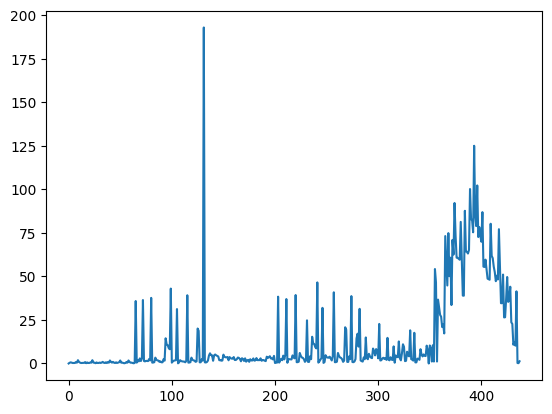

In [542]:
#for n in song.instruments[0].notes:
#    print(n)
#for n in x:
#    print(n) 
scores = []
for s in x:
    scores.append(s[1])
plt.plot(scores)

estimate_key(x)
print(convert_list_chords_to_relative(x))